Este ETL (Extract, Transform, Load) se enfoca en el procesamiento de datos de diferentes conjuntos de datos de taxis. El objetivo principal es realizar transformaciones en los datos y cargarlos en un formato adecuado para su posterior análisis.

El flujo de trabajo comienza con la extracción de datos de múltiples archivos parquet que contienen información sobre viajes de taxis. Estos archivos se leen utilizando la biblioteca `pyarrow` y se almacenan en diferentes DataFrames de pandas.

A continuación, se realizan varias transformaciones en los datos. Esto incluye la eliminación de valores nulos, el cálculo de la duración del viaje en minutos y la filtración de los viajes que duran 30 minutos o menos. También se crean nuevas columnas para representar los intervalos de duración del viaje y se agrupan los datos por diferentes dimensiones, como el proveedor de taxis, el mes y el período del día.

Una vez que se han realizado todas las transformaciones, los datos transformados se cargan en diferentes gráficos de barras utilizando la biblioteca `matplotlib`. Estos gráficos representan la cantidad de viajes y la cantidad de dinero ganada por cada período del día para diferentes tipos de taxis.

In [273]:
import pandas as pd
import numpy as np
import datetime as dt
import pyarrow.parquet as pq
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns

In [293]:
yellow_taxis_data= pd.read_parquet('../parquet/yellow_tripdata_2023-10.parquet', engine='pyarrow')
green_taxis_data=pd.read_parquet('../parquet/green_tripdata_2023-10.parquet', engine='pyarrow')
fhv_taxi_data=pd.read_parquet('../parquet/fhv_tripdata_2023-10.parquet', engine='pyarrow')

In [294]:
yellow_taxis_data.info()
green_taxis_data.info()
fhv_taxi_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3522285 entries, 0 to 3522284
Data columns (total 19 columns):
 #   Column                 Dtype         
---  ------                 -----         
 0   VendorID               int32         
 1   tpep_pickup_datetime   datetime64[us]
 2   tpep_dropoff_datetime  datetime64[us]
 3   passenger_count        float64       
 4   trip_distance          float64       
 5   RatecodeID             float64       
 6   store_and_fwd_flag     object        
 7   PULocationID           int32         
 8   DOLocationID           int32         
 9   payment_type           int64         
 10  fare_amount            float64       
 11  extra                  float64       
 12  mta_tax                float64       
 13  tip_amount             float64       
 14  tolls_amount           float64       
 15  improvement_surcharge  float64       
 16  total_amount           float64       
 17  congestion_surcharge   float64       
 18  Airport_fee           

In [286]:
def eliminar_null_values(df):
    print("Valores nulos antes de la eliminación:")
    print(df.isnull().sum())
    
    df.dropna(inplace=True)
    
    print("\nValores nulos después de la eliminación:")
    print(df.isnull().sum())

# Llamar a la función con el DataFrame
eliminar_null_values(yellow_taxis_data)

Valores nulos antes de la eliminación:
VendorID                      0
tpep_pickup_datetime          0
tpep_dropoff_datetime         0
passenger_count          154929
trip_distance                 0
RatecodeID               154929
store_and_fwd_flag       154929
PULocationID                  0
DOLocationID                  0
payment_type                  0
fare_amount                   0
extra                         0
mta_tax                       0
tip_amount                    0
tolls_amount                  0
improvement_surcharge         0
total_amount                  0
congestion_surcharge     154929
Airport_fee              154929
dtype: int64

Valores nulos después de la eliminación:
VendorID                 0
tpep_pickup_datetime     0
tpep_dropoff_datetime    0
passenger_count          0
trip_distance            0
RatecodeID               0
store_and_fwd_flag       0
PULocationID             0
DOLocationID             0
payment_type             0
fare_amount              0
e

In [287]:
def eliminar_null_values(df):
    print("Valores nulos antes de la eliminación:")
    print(df.isnull().sum())
    
    df.dropna(inplace=True)
    
    print("\nValores nulos después de la eliminación:")
    print(df.isnull().sum())

# Llamar a la función con el DataFrame
eliminar_null_values(green_taxis_data)

Valores nulos antes de la eliminación:
VendorID                     0
lpep_pickup_datetime         0
lpep_dropoff_datetime        0
store_and_fwd_flag        4677
RatecodeID                4677
PULocationID                 0
DOLocationID                 0
passenger_count           4677
trip_distance                0
fare_amount                  0
extra                        0
mta_tax                      0
tip_amount                   0
tolls_amount                 0
ehail_fee                66177
improvement_surcharge        0
total_amount                 0
payment_type              4677
trip_type                 4678
congestion_surcharge      4677
dtype: int64

Valores nulos después de la eliminación:
VendorID                 0
lpep_pickup_datetime     0
lpep_dropoff_datetime    0
store_and_fwd_flag       0
RatecodeID               0
PULocationID             0
DOLocationID             0
passenger_count          0
trip_distance            0
fare_amount              0
extra           

In [295]:
# Calcular la duración del viaje en minutos
green_taxis_data.loc[:,'trip_duration'] = (green_taxis_data['lpep_dropoff_datetime'] - green_taxis_data['lpep_pickup_datetime']).dt.total_seconds() / 60
yellow_taxis_data.loc[:,'trip_duration'] = (yellow_taxis_data['tpep_dropoff_datetime'] - yellow_taxis_data['tpep_pickup_datetime']).dt.total_seconds() / 60
fhv_taxi_data.loc[:,'trip_time'] = (fhv_taxi_data['dropOff_datetime'] - fhv_taxi_data['pickup_datetime']).dt.total_seconds() / 60

# Filtrar los viajes que duran 30 minutos o menos
green_taxis_data = green_taxis_data[green_taxis_data['trip_duration'] <= 30]
yellow_taxis_data = yellow_taxis_data[yellow_taxis_data['trip_duration'] <= 30]
fhv_taxi_data = fhv_taxi_data[fhv_taxi_data['trip_time'] <= 30]

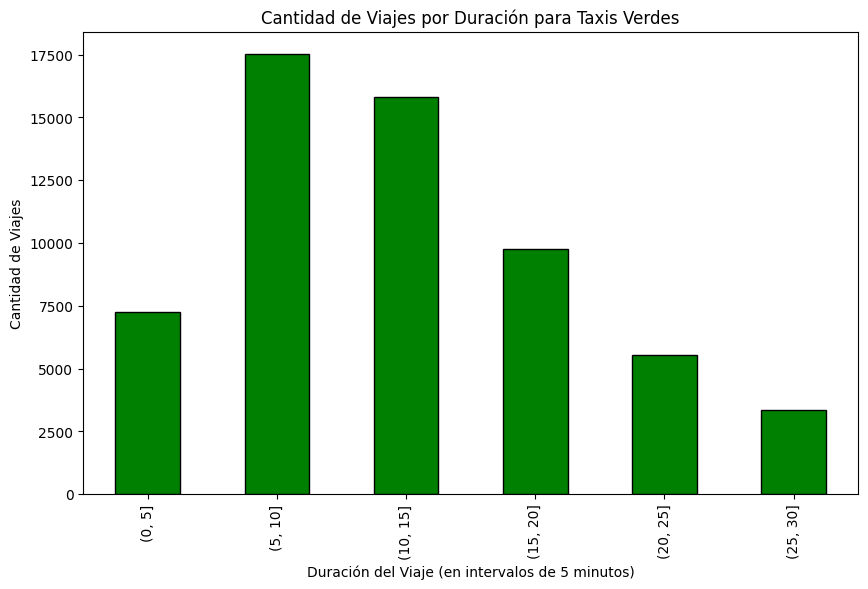

In [297]:
# Crear una nueva columna que represente los intervalos de duración del viaje
green_taxis_data['trip_duration_interval'] = pd.cut(green_taxis_data['trip_duration'], bins=range(0, 35, 5))

# Crear un gráfico de barras de la cantidad de viajes en cada intervalo de duración
plt.figure(figsize=(10,6))
green_taxis_data['trip_duration_interval'].value_counts().sort_index().plot(kind='bar', color='green', edgecolor='black')
plt.xlabel('Duración del Viaje (en intervalos de 5 minutos)')
plt.ylabel('Cantidad de Viajes')
plt.title('Cantidad de Viajes por Duración para Taxis Verdes')
plt.show()

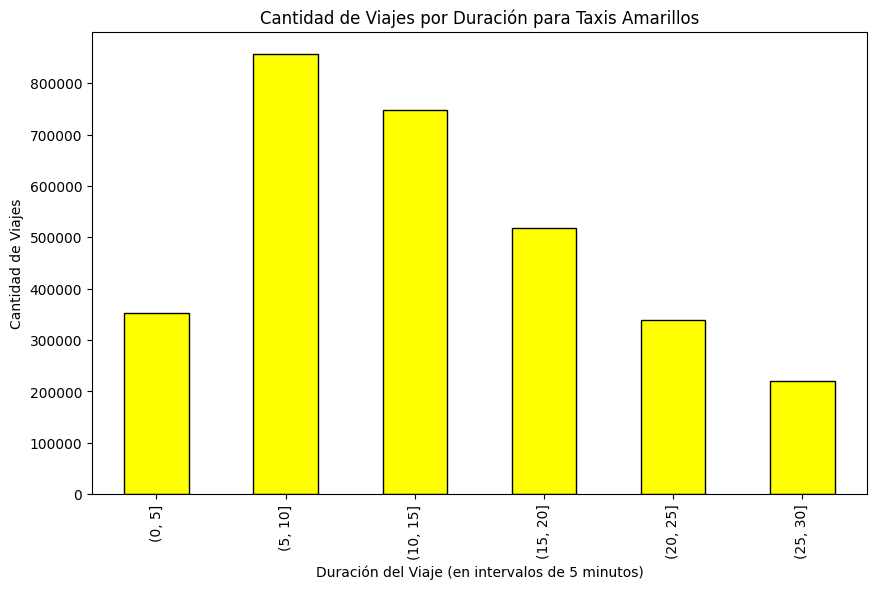

In [298]:
# Crear una nueva columna que represente los intervalos de duración del viaje
yellow_taxis_data['trip_duration_interval'] = pd.cut(yellow_taxis_data['trip_duration'], bins=range(0, 35, 5))

# Crear un gráfico de barras de la cantidad de viajes en cada intervalo de duración
plt.figure(figsize=(10,6))
yellow_taxis_data['trip_duration_interval'].value_counts().sort_index().plot(kind='bar', color='yellow', edgecolor='black')
plt.xlabel('Duración del Viaje (en intervalos de 5 minutos)')
plt.ylabel('Cantidad de Viajes')
plt.title('Cantidad de Viajes por Duración para Taxis Amarillos')
plt.show()

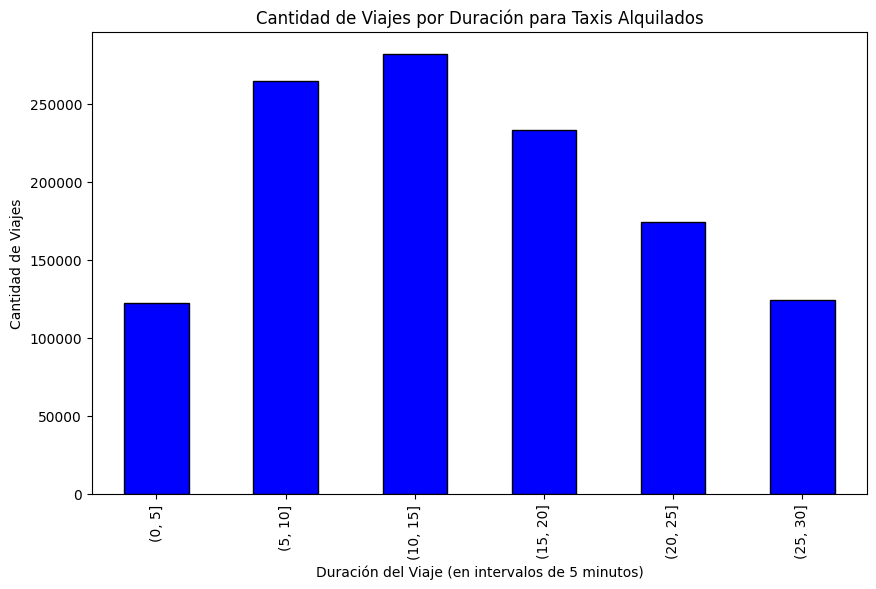

In [300]:
# Crear una nueva columna que represente los intervalos de duración del viaje
fhv_taxi_data['trip_duration_interval'] = pd.cut(fhv_taxi_data['trip_time'], bins=range(0, 35, 5))

# Crear un gráfico de barras de la cantidad de viajes en cada intervalo de duración
plt.figure(figsize=(10,6))
fhv_taxi_data['trip_duration_interval'].value_counts().sort_index().plot(kind='bar', color='blue', edgecolor='black')
plt.xlabel('Duración del Viaje (en intervalos de 5 minutos)')
plt.ylabel('Cantidad de Viajes')
plt.title('Cantidad de Viajes por Duración para Taxis Alquilados')
plt.show()

In [301]:
# Convertir la columna de fecha y hora a formato de fecha y hora si aún no lo está
yellow_taxis_data['tpep_pickup_datetime'] = pd.to_datetime(yellow_taxis_data['tpep_pickup_datetime'])

# Crear una columna para el mes y la hora del día
yellow_taxis_data['month'] = yellow_taxis_data['tpep_pickup_datetime'].dt.month
yellow_taxis_data['hour'] = yellow_taxis_data['tpep_pickup_datetime'].dt.hour

# Definir los rangos de horas para la mañana, tarde y noche
bins = [0, 6, 12, 18, 24]
periodo = ['Noche', 'Mañana', 'Tarde', 'Noche2']
yellow_taxis_data['day_period'] = pd.cut(yellow_taxis_data['hour'], bins=bins, labels=periodo, right=False)
yellow_taxis_data['day_period'] = yellow_taxis_data['day_period'].replace('Noche2', 'Noche')

# Calcular la cantidad de dinero generada por cada taxi en cada período del día
dinero_ganado_por_dia = yellow_taxis_data.groupby(['VendorID', 'month', 'day_period'], observed=True)['fare_amount'].sum().reset_index()

# Calcular la cantidad de dinero generada por cada taxi en cada mes
dinero_ganado_por_mes = yellow_taxis_data.groupby(['VendorID', 'month'], observed=True)['fare_amount'].sum().reset_index()

In [302]:
# Imprimir los primeros 5 registros de dinero ganado por día
dinero_ganado_por_dia.head()

,VendorID,month,day_period,fare_amount
0,1,10,Noche,5014642.95
1,1,10,Mañana,2642887.63
2,1,10,Tarde,3860369.57
3,2,1,Tarde,12.10
4,2,9,Noche,412.20


In [303]:
dinero_ganado_por_mes.head()

,VendorID,month,fare_amount
0,1,10,11517900.15
1,2,1,12.10
2,2,9,412.20
3,2,10,33918176.83
4,2,11,365.60


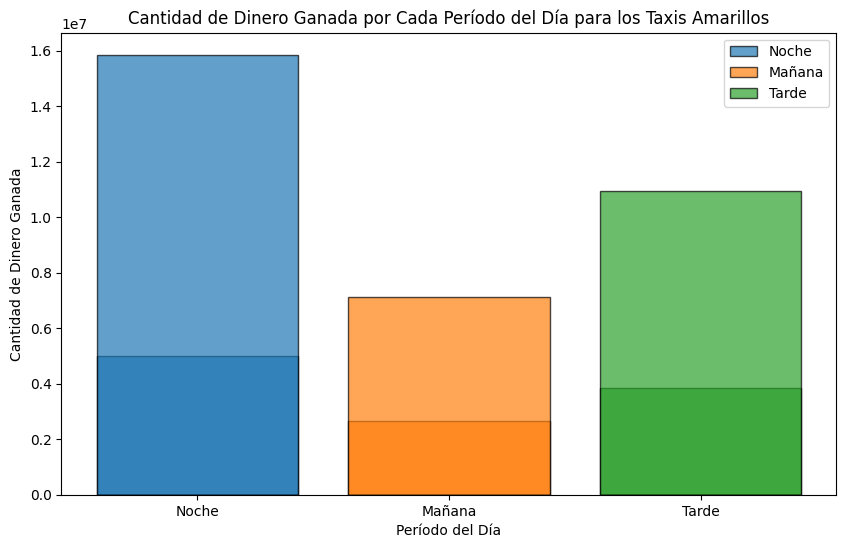

In [304]:
# Crear un gráfico de barras de la cantidad de dinero ganada por cada período del día
plt.figure(figsize=(10,6))
for period in ['Noche', 'Mañana', 'Tarde']:
    subset = dinero_ganado_por_dia[dinero_ganado_por_dia['day_period'] == period]
    plt.bar(subset['day_period'], subset['fare_amount'], label=period, alpha=0.7, edgecolor='black')

plt.xlabel('Período del Día')
plt.ylabel('Cantidad de Dinero Ganada')
plt.title('Cantidad de Dinero Ganada por Cada Período del Día para los Taxis Amarillos')
plt.legend()
plt.show()


In [305]:
# Convertir la columna de fecha y hora a formato de fecha y hora si aún no lo está
green_taxis_data['lpep_pickup_datetime'] = pd.to_datetime(green_taxis_data['lpep_pickup_datetime'])

# Crear una columna para el mes y la hora del día
green_taxis_data['month'] = green_taxis_data['lpep_pickup_datetime'].dt.month
green_taxis_data['hour'] = green_taxis_data['lpep_pickup_datetime'].dt.hour

# Definir los rangos de horas para la mañana, tarde y noche
bins = [0, 6, 12, 18, 24]
periodo = ['Noche', 'Mañana', 'Tarde', 'Noche2']
green_taxis_data['day_period'] = pd.cut(green_taxis_data['hour'], bins=bins, labels=periodo, right=False)
green_taxis_data['day_period'] = green_taxis_data['day_period'].replace('Noche2', 'Noche')

# Calcular la cantidad de dinero generada por cada taxi en cada período del día
dinero_ganado_por_dia_green = green_taxis_data.groupby(['VendorID', 'month', 'day_period'], observed=True)['fare_amount'].sum().reset_index()

# Calcular la cantidad de dinero generada por cada taxi en cada mes
dinero_ganado_por_mes_green = green_taxis_data.groupby(['VendorID', 'month'], observed=True)['fare_amount'].sum().reset_index()

In [306]:
dinero_ganado_por_dia_green.head()

,VendorID,month,day_period,fare_amount
0,1,10,Noche,33642.66
1,1,10,Mañana,32242.33
2,1,10,Tarde,41611.63
3,2,9,Noche,36.50
4,2,10,Noche,305506.73


In [307]:
dinero_ganado_por_mes_green.head()

,VendorID,month,fare_amount
0,1,10,107496.62
1,2,9,36.50
2,2,10,818551.72


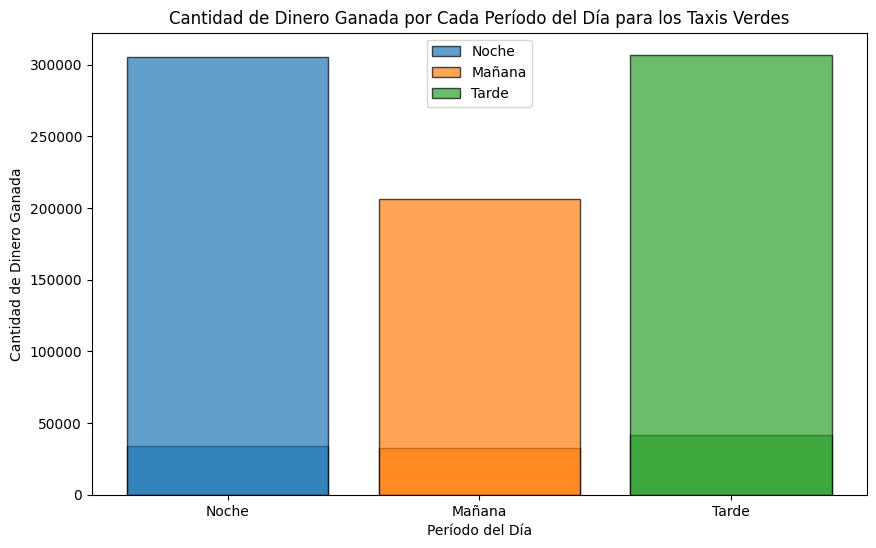

In [308]:
# Crear un gráfico de barras de la cantidad de dinero ganada por cada período del día
plt.figure(figsize=(10,6))
for period in ['Noche', 'Mañana', 'Tarde']:
    subset = dinero_ganado_por_dia_green[dinero_ganado_por_dia_green['day_period'] == period]
    plt.bar(subset['day_period'], subset['fare_amount'], label=period, alpha=0.7, edgecolor='black')

plt.xlabel('Período del Día')
plt.ylabel('Cantidad de Dinero Ganada')
plt.title('Cantidad de Dinero Ganada por Cada Período del Día para los Taxis Verdes')
plt.legend()
plt.show()


In [309]:
fhvhv_taxi_data=pd.read_parquet('../parquet/fhvhv_tripdata_2023-10.parquet', engine='pyarrow')

In [310]:
fhvhv_taxi_data

,hvfhs_license_num,dispatching_base_num,originating_base_num,request_datetime,on_scene_datetime,pickup_datetime,dropoff_datetime,PULocationID,DOLocationID,trip_miles,...,sales_tax,congestion_surcharge,airport_fee,tips,driver_pay,shared_request_flag,shared_match_flag,access_a_ride_flag,wav_request_flag,wav_match_flag
0,HV0003,B03404,B03404,2023-10-01 00:36:27,2023-10-01 00:38:11,2023-10-01 00:39:13,2023-10-01 01:06:47,24,114,6.780,...,2.64,2.75,0.0,0.00,24.46,N,N,,N,N
1,HV0003,B03404,B03404,2023-10-01 00:02:41,2023-10-01 00:06:24,2023-10-01 00:07:30,2023-10-01 00:31:52,258,255,9.000,...,2.77,0.00,0.0,0.00,25.57,N,N,,N,N
2,HV0003,B03404,B03404,2023-10-01 00:29:22,2023-10-01 00:33:52,2023-10-01 00:34:48,2023-10-01 01:10:17,255,265,22.450,...,7.79,0.00,0.0,0.00,55.64,N,N,,N,N
3,HV0003,B03404,B03404,2023-09-30 23:57:00,2023-10-01 00:03:35,2023-10-01 00:04:04,2023-10-01 00:14:15,256,148,2.320,...,1.68,2.75,0.0,3.58,20.40,N,N,,N,N
4,HV0003,B03404,B03404,2023-10-01 00:14:45,2023-10-01 00:24:24,2023-10-01 00:24:24,2023-10-01 00:40:56,148,141,4.860,...,3.25,2.75,0.0,0.00,31.62,N,N,,N,N
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20186325,HV0005,B03406,None,2023-10-31 23:15:18,NaT,2023-10-31 23:19:42,2023-10-31 23:28:57,41,42,1.832,...,0.95,0.00,0.0,0.00,7.69,N,N,N,N,N
20186326,HV0003,B03404,B03404,2023-10-31 22:59:20,2023-10-31 23:01:46,2023-10-31 23:02:54,2023-10-31 23:22:20,142,158,3.610,...,2.09,2.75,0.0,0.00,16.04,N,N,N,N,N
20186327,HV0003,B03404,B03404,2023-10-31 23:21:55,2023-10-31 23:24:02,2023-10-31 23:24:19,2023-10-31 23:38:36,158,162,3.040,...,2.00,2.75,0.0,0.00,12.38,N,N,N,N,N
20186328,HV0003,B03404,B03404,2023-10-31 23:42:09,2023-10-31 23:44:50,2023-10-31 23:45:13,2023-10-31 23:59:51,162,45,4.690,...,2.16,2.75,0.0,0.00,14.75,N,N,N,N,N


In [311]:
# Convertir la columna de fecha y hora a formato de fecha y hora si aún no lo está
fhvhv_taxi_data['pickup_datetime'] = pd.to_datetime(fhvhv_taxi_data['pickup_datetime'])

# Crear una columna para el mes y la hora del día
fhvhv_taxi_data['month'] = fhvhv_taxi_data['pickup_datetime'].dt.month
fhvhv_taxi_data['hour'] = fhvhv_taxi_data['pickup_datetime'].dt.hour

# Definir los rangos de horas para la mañana, tarde y noche
bins = [0, 6, 12, 18, 24]
periodo = ['Noche', 'Mañana', 'Tarde', 'Noche2']
fhvhv_taxi_data['day_period'] = pd.cut(fhvhv_taxi_data['hour'], bins=bins, labels=periodo, right=False)
fhvhv_taxi_data['day_period'] = fhvhv_taxi_data['day_period'].replace('Noche2', 'Noche')

# Calcular la cantidad de dinero generada por cada taxi en cada período del día
dinero_ganado_por_dia_fhv = fhvhv_taxi_data.groupby(['hvfhs_license_num', 'month', 'day_period'], observed=True)['tolls'].sum().reset_index()

# Calcular la cantidad de dinero generada por cada taxi en cada mes
dinero_ganado_por_mes_fhv = fhvhv_taxi_data.groupby(['hvfhs_license_num', 'month'], observed=True)['tolls'].sum().reset_index()

In [312]:
dinero_ganado_por_dia_fhv.head()

,hvfhs_license_num,month,day_period,tolls
0,HV0003,10,Noche,8303511.10
1,HV0003,10,Mañana,4139833.50
2,HV0003,10,Tarde,5216440.88
3,HV0005,10,Noche,3240844.37
4,HV0005,10,Mañana,1527304.76


In [313]:
dinero_ganado_por_mes_fhv.head()

,hvfhs_license_num,month,tolls
0,HV0003,10,17659785.48
1,HV0005,10,6437700.34


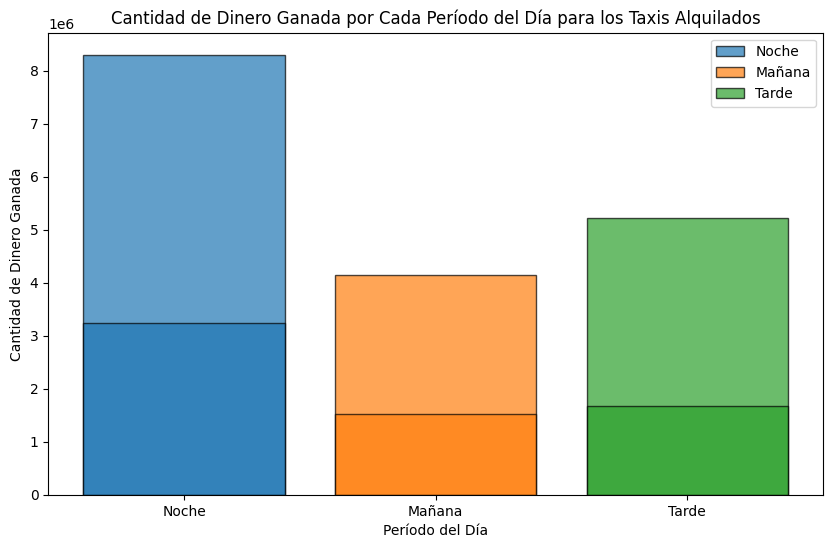

In [314]:
# Crear un gráfico de barras de la cantidad de dinero ganada por cada período del día
plt.figure(figsize=(10,6))
for period in ['Noche', 'Mañana', 'Tarde']:
    subset = dinero_ganado_por_dia_fhv[dinero_ganado_por_dia_fhv['day_period'] == period]
    plt.bar(subset['day_period'], subset['tolls'], label=period, alpha=0.7, edgecolor='black')

plt.xlabel('Período del Día')
plt.ylabel('Cantidad de Dinero Ganada')
plt.title('Cantidad de Dinero Ganada por Cada Período del Día para los Taxis Alquilados')
plt.legend()
plt.show()
